# Task 1 : Set up colab gpu runtime environment

In [2]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python
!pip install albucore==0.0.23
!pip install -U albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-26jylwad
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-26jylwad
  Resolved https://github.com/albumentations-team/albumentations to commit 190ce313a143689e59ca727f799b729078a89285
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.24
    Uninstalling albucore-0.0.24:
      Successfully uninstalled albucore-0.0.24


# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

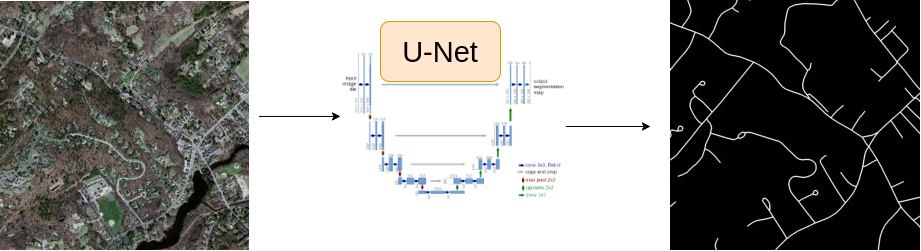

# Download Subset Dataset

In [3]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411 (from 1)
Receiving objects: 100% (411/411), 851.74 MiB | 49.34 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Some Common Imports

In [4]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [5]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [6]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [7]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [10]:
idx = 15

row = df.iloc[idx]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255

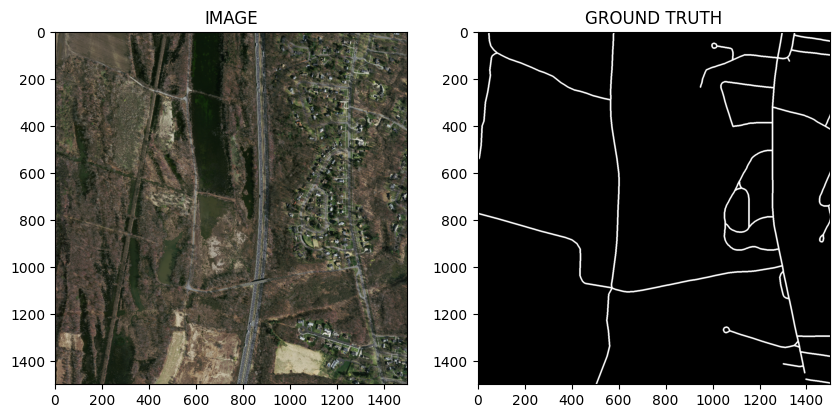

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [12]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [16]:
import albumentations as A

In [17]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
  ])

# Task 4 : Create Custom Dataset

In [18]:
from torch.utils.data import Dataset

In [23]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #(h, w, c)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h, w)
    mask = np.expand_dims(mask, axis = -1) #(h, w, c)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image'] #(h, w, c)
      mask = data['mask']

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [24]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [25]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 159
Size of Validset : 40


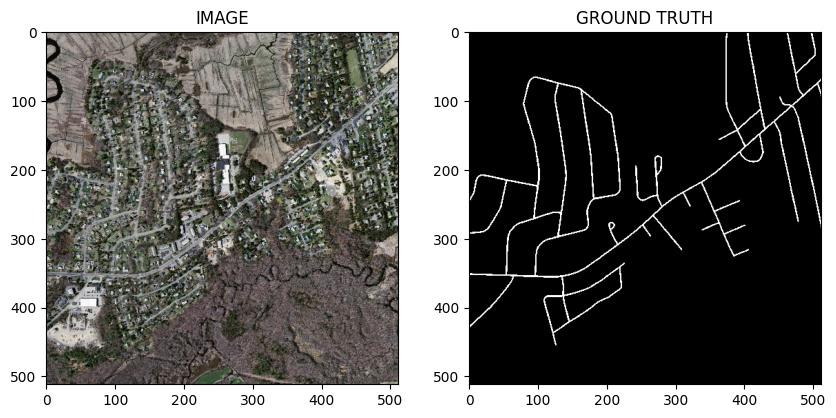

In [29]:
idx = 21

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [30]:
from torch.utils.data import DataLoader

In [31]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [32]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 20
total no. of batches in validloader : 5


In [35]:
for images, masks in trainloader:
  print(f"One batch image shape : {images.shape}")
  print(f"One batch mask shape : {masks.shape}")
  break;

One batch image shape : torch.Size([8, 3, 512, 512])
One batch mask shape : torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [36]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [37]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.backbone(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [41]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function

In [42]:
def train_fn(data_loader, model, optimizer):

  model.train() # Turn ON dropout, batchnorm, etc..
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [43]:
def eval_fn(data_loader, model):

  model.eval() #Turn OFF dropout, batchnorm, etc..
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits, loss = model(images, masks)
      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [44]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [46]:
best_loss = np.inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED MODEL")
    best_loss = valid_loss

  print(f"Epoch : {i+1}  Train_loss : {train_loss}  Valid_loss : {valid_loss}")

100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


SAVED MODEL
Epoch : 1  Train_loss : 1.1952398538589477  Valid_loss : 1.008908760547638


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


SAVED MODEL
Epoch : 2  Train_loss : 0.8063771456480027  Valid_loss : 0.8203077912330627


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


SAVED MODEL
Epoch : 3  Train_loss : 0.7115688383579254  Valid_loss : 0.7519047856330872


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


SAVED MODEL
Epoch : 4  Train_loss : 0.6883193612098694  Valid_loss : 0.7412231683731079


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


SAVED MODEL
Epoch : 5  Train_loss : 0.6611936777830124  Valid_loss : 0.6825857281684875


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch : 6  Train_loss : 0.6639459043741226  Valid_loss : 0.7700880646705628


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch : 7  Train_loss : 0.6650366485118866  Valid_loss : 0.6966538786888122


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch : 8  Train_loss : 0.6440969973802566  Valid_loss : 0.714025366306305


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


SAVED MODEL
Epoch : 9  Train_loss : 0.627800464630127  Valid_loss : 0.6717064499855041


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch : 10  Train_loss : 0.6229836389422416  Valid_loss : 0.6986709117889405


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


SAVED MODEL
Epoch : 11  Train_loss : 0.6105625778436661  Valid_loss : 0.6675907135009765


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch : 12  Train_loss : 0.6063513845205307  Valid_loss : 0.6737246513366699


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


SAVED MODEL
Epoch : 13  Train_loss : 0.6129622504115104  Valid_loss : 0.6523028969764709


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch : 14  Train_loss : 0.6022977352142334  Valid_loss : 0.6655398726463317


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


SAVED MODEL
Epoch : 15  Train_loss : 0.6043918088078499  Valid_loss : 0.6380832195281982


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch : 16  Train_loss : 0.5910718023777009  Valid_loss : 0.67548748254776


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch : 17  Train_loss : 0.5953067362308502  Valid_loss : 0.6530189514160156


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


SAVED MODEL
Epoch : 18  Train_loss : 0.5855101108551025  Valid_loss : 0.6344160914421082


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch : 19  Train_loss : 0.5708889052271843  Valid_loss : 0.6500118374824524


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch : 20  Train_loss : 0.5793280929327012  Valid_loss : 0.6579863429069519


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Epoch : 21  Train_loss : 0.5710445582866669  Valid_loss : 0.6683799982070923


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


SAVED MODEL
Epoch : 22  Train_loss : 0.5772313266992569  Valid_loss : 0.628577184677124


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch : 23  Train_loss : 0.5816806554794312  Valid_loss : 0.6797710180282592


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch : 24  Train_loss : 0.5743948683142662  Valid_loss : 0.6650235652923584


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]

SAVED MODEL
Epoch : 25  Train_loss : 0.5661845102906227  Valid_loss : 0.6188425779342651


# Task 9 : Inference

In [54]:
idx = 30

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(C, H, W) -> (b, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

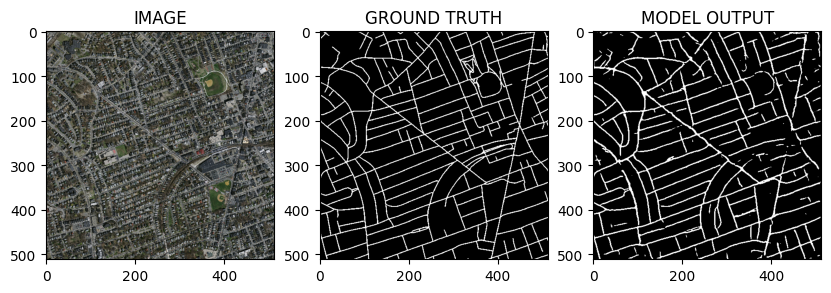

In [55]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya

